In [1]:
%reload_ext autoreload
%autoreload 2

In [ ]:
import sys, os

# Get absolute path to the project root
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.append(PROJECT_ROOT)

sys.path.append("/cluster/home/herminea/mental_health_project/workspace/utils")
sys.path.append("/cluster/home/herminea/mental_health_project/workspace/scripts")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.spatial.distance import pdist, squareform
from utils.io_results import load_results, group_results_by_subject

# --- Load combined FCs ---
RES_DIR = "/cluster/home/herminea/mental_health_project/workspace/results/fmri_prep/mvmd/combined_fc"

In [3]:
def load_fc_data(res_dir):
    results = load_results(res_dir)
    subjects_combined = group_results_by_subject(results)

    fcs_by_imf = defaultdict(dict)
    groups = {}
    freqs_by_imf = defaultdict(list)

    for subj, entries in subjects_combined.items():
        entry = entries[0]
        groups[subj] = entry["group"]
        fcs_by_imf["whole"][subj] = entry["fc_whole"]
        for i, fc in enumerate(entry["fc_modes"], start=1):
            fcs_by_imf[i][subj] = fc
            freqs_by_imf[i].append(entry["freqs"][i-1])

    return subjects_combined, fcs_by_imf, groups, freqs_by_imf

def flatten_fc(fc):
    iu = np.triu_indices(fc.shape[0], 1)
    return fc[iu]

def compute_similarity_matrix(fcs):
    subs = list(fcs.keys())
    X = np.array([flatten_fc(fcs[s]) for s in subs])
    sim = 1 - squareform(pdist(X, metric='correlation'))
    return sim, subs

def group_similarity_means(sim, subs, groups):
    mdd_idx = [i for i, s in enumerate(subs) if groups[s] == "MDD"]
    hc_idx  = [i for i, s in enumerate(subs) if groups[s] == "HC"]

    MDD_MDD = np.nanmean(sim[np.ix_(mdd_idx, mdd_idx)][~np.eye(len(mdd_idx), dtype=bool)])
    HC_HC   = np.nanmean(sim[np.ix_(hc_idx, hc_idx)][~np.eye(len(hc_idx), dtype=bool)])
    MDD_HC  = np.nanmean(sim[np.ix_(mdd_idx, hc_idx)])
    return MDD_MDD, HC_HC, MDD_HC

def hedges_g(x1, x2):
    """Compute Hedges' g (bias-corrected Cohen's d) for two independent samples."""
    x1, x2 = np.asarray(x1), np.asarray(x2)
    x1, x2 = x1[~np.isnan(x1)], x2[~np.isnan(x2)]
    if len(x1) < 2 or len(x2) < 2:
        return np.nan
    
    n1, n2 = len(x1), len(x2)
    s1, s2 = np.nanstd(x1, ddof=1), np.nanstd(x2, ddof=1)
    s_pooled = np.sqrt(((n1 - 1)*s1**2 + (n2 - 1)*s2**2) / (n1 + n2 - 2))
    d = (np.nanmean(x1) - np.nanmean(x2)) / s_pooled

    # Correction for small sample bias
    correction = 1 - (3 / (4*(n1 + n2) - 9))
    g = d * correction
    return g


def cohen_d(x1, x2):
    """Compute Cohen's d for two independent samples (handles NaNs)."""
    x1, x2 = np.asarray(x1), np.asarray(x2)
    x1, x2 = x1[~np.isnan(x1)], x2[~np.isnan(x2)]
    if len(x1) < 2 or len(x2) < 2:
        return np.nan
    n1, n2 = len(x1), len(x2)
    s1, s2 = np.nanstd(x1, ddof=1), np.nanstd(x2, ddof=1)
    s_pooled = np.sqrt(((n1 - 1)*s1**2 + (n2 - 1)*s2**2) / (n1 + n2 - 2))
    return (np.nanmean(x1) - np.nanmean(x2)) / s_pooled


def permutation_test_within_vs_between(sim, subs, groups, n_perm=5000, seed=42):
    rng = np.random.default_rng(seed)
    mdd_idx = [i for i, s in enumerate(subs) if groups[s] == "MDD"]
    hc_idx  = [i for i, s in enumerate(subs) if groups[s] == "HC"]

    within = np.concatenate([
        sim[np.ix_(mdd_idx, mdd_idx)][~np.eye(len(mdd_idx), dtype=bool)],
        sim[np.ix_(hc_idx, hc_idx)][~np.eye(len(hc_idx), dtype=bool)]
    ])
    between = sim[np.ix_(mdd_idx, hc_idx)].ravel()
    true_diff = np.mean(within) - np.mean(between)

    all_idx = np.arange(len(subs))
    n_mdd = len(mdd_idx)
    perm_diffs = np.empty(n_perm)
    for k in range(n_perm):
        rng.shuffle(all_idx)
        MDD_p, HC_p = all_idx[:n_mdd], all_idx[n_mdd:]
        within_p = np.concatenate([
            sim[np.ix_(MDD_p, MDD_p)][~np.eye(len(MDD_p), dtype=bool)],
            sim[np.ix_(HC_p, HC_p)][~np.eye(len(HC_p), dtype=bool)]
        ])
        between_p = sim[np.ix_(MDD_p, HC_p)].ravel()
        perm_diffs[k] = np.mean(within_p) - np.mean(between_p)

    pval = np.mean(np.abs(perm_diffs) >= np.abs(true_diff))
    return true_diff, pval

def analyze_similarity_by_imf(fcs_by_imf, groups):
    results = []
    for imf_idx, fcs in fcs_by_imf.items():
        sim, subs = compute_similarity_matrix(fcs)
        MDD_MDD, HC_HC, MDD_HC = group_similarity_means(sim, subs, groups)
        diff, pval = permutation_test_within_vs_between(sim, subs, groups)
        results.append((imf_idx, MDD_MDD, HC_HC, MDD_HC, diff, pval))
    return pd.DataFrame(results, columns=["IMF", "MDD–MDD", "HC–HC", "MDD–HC", "Δ", "p"])

In [4]:
subjects_combined, fcs_by_imf, groups, freqs_by_imf = load_fc_data(RES_DIR)


[Load] Loaded 42 FC result files from /cluster/home/herminea/mental_health_project/test/results/fmri_prep/mvmd/combined_fc


#### Frequency bands

In [5]:
def bin_fcs_by_freq(subjects_combined, freq_bands):
    binned = {band: defaultdict(list) for band in freq_bands}
    
    for subj, entries in subjects_combined.items():
        e = entries[0]
        # Assign each IMF FC to its corresponding frequency band
        for f, fc in zip(e["freqs"], e["fc_modes"]):
            for band, (fmin, fmax) in freq_bands.items():
                if fmin <= f < fmax:
                    binned[band][subj].append(fc)
                    


    # Average FCs per subject for each band
    binned_mean = {
        band: {s: np.nanmean(fcs, axis=0) for s, fcs in subj_dict.items()}
        for band, subj_dict in binned.items()
    }

    return binned_mean



In [6]:
freq_bands = {
    #"Slow-6": (0.005, 0.01),
    "Slow-5": (0.01, 0.027),
    "Slow-4": (0.027, 0.073),
    "Slow-3": (0.073, 0.198),
    "Slow-2": (0.198, 0.25),
}

fcs_by_band = bin_fcs_by_freq(subjects_combined, freq_bands)
fcs_by_band["Whole"] = {s: fcs_by_imf["whole"][s] for s in fcs_by_imf["whole"]}

from collections import OrderedDict

order = ["Whole", "Slow-6", "Slow-5", "Slow-4", "Slow-3", "Slow-2"]
fcs_by_band = OrderedDict((k, fcs_by_band[k]) for k in order if k in fcs_by_band)

summary_band = []
for band, fcs in fcs_by_band.items():
    sim, subs = compute_similarity_matrix(fcs)
    MDD_MDD, HC_HC, MDD_HC = group_similarity_means(sim, subs, groups)
    diff, pval = permutation_test_within_vs_between(sim, subs, groups)
    summary_band.append((band, MDD_MDD, HC_HC, MDD_HC, diff, pval))
summary_band = pd.DataFrame(summary_band, columns=["Band", "MDD–MDD", "HC–HC", "MDD–HC", "Δ", "p"])
print(summary_band)

     Band   MDD–MDD     HC–HC    MDD–HC         Δ       p
0   Whole  0.645664  0.627328  0.639983 -0.003487  0.3204
1  Slow-5  0.456609  0.493332  0.476154 -0.000266  0.9514
2  Slow-4  0.527821  0.541860  0.534671  0.000169  0.9556
3  Slow-3  0.460673  0.464514  0.464445 -0.001851  0.5742
4  Slow-2  0.227180  0.180284  0.207369 -0.011568  0.1632


#### Network aggregation

In [ ]:
def aggregate_to_network_fc(fc, roi_to_net, n_networks):
    net_fc = np.zeros((n_networks, n_networks))
    for i in range(n_networks):
        idx_i = np.where(roi_to_net == i)[0]
        for j in range(n_networks):
            idx_j = np.where(roi_to_net == j)[0]
            vals = fc[np.ix_(idx_i, idx_j)]
            net_fc[i, j] = np.nanmean(vals)
    net_fc = (net_fc + net_fc.T) / 2
    #np.fill_diagonal(net_fc, 0)
    return net_fc

import pandas as pd
import numpy as np

# --- Load mapping file ---
atlas_df = pd.read_csv("/cluster/home/herminea/mental_health_project/workspace/atlas/roi_to_net_434.csv")

# --- Extract columns cleanly ---
atlas_df["NetworkID"] = pd.to_numeric(atlas_df["NetworkID"], errors="coerce").astype(int)
atlas_df["NetworkName"] = atlas_df["NetworkName"].astype(str)


# ROI → network mapping (numeric, 0–20)
roi_to_net = atlas_df["NetworkID"].values
n_networks = len(np.unique(roi_to_net))

# --- Group by numeric ID and take the first name per network ---
net_names_21 = (
    atlas_df.groupby("NetworkID")["NetworkName"]
    .first()
    .to_list()
)
binned_netfcs = {
    band: {s: aggregate_to_network_fc(fc, roi_to_net, n_networks)
           for s, fc in subj_dict.items()}
    for band, subj_dict in fcs_by_band.items()
}

whole_netfcs = {
    s: aggregate_to_network_fc(fc, roi_to_net, n_networks)
    for s, fc in fcs_by_imf["whole"].items()
}


In [8]:
import numpy as np

z_binned_netfcs = {}

for band, subj_fcs in binned_netfcs.items():
    z_binned_netfcs[band] = {}
    for s, fc in subj_fcs.items():
        # Assume fc is Pearson r. Clip to avoid infs.
        fc_clipped = np.clip(fc, -0.999999, 0.999999)
        z_binned_netfcs[band][s] = np.arctanh(fc_clipped)  # Fisher z

#### Statistical testing

In [9]:
def networkpair_permtest(mdd_mats, hc_mats, n_perm=5000):
    n_net = mdd_mats.shape[1]
    diff_mat = np.zeros((n_net, n_net))
    p_mat = np.ones((n_net, n_net))
    d_mat = np.zeros((n_net, n_net))
    g_mat = np.zeros((n_net, n_net))

    for i in range(n_net):
        for j in range(i+1, n_net):
            mdd_vals = mdd_mats[:, i, j]
            hc_vals  = hc_mats[:, i, j]

            # Compute group mean difference
            true_diff = np.nanmean(mdd_vals) - np.nanmean(hc_vals)

            # Compute permutation p-value
            combined = np.concatenate([mdd_vals, hc_vals])
            n_mdd = len(mdd_vals)
            perm_diffs = np.zeros(n_perm)
            for p in range(n_perm):
                perm = np.random.permutation(combined)
                perm_diffs[p] = np.mean(perm[:n_mdd]) - np.mean(perm[n_mdd:])
            p_val = np.mean(np.abs(perm_diffs) >= np.abs(true_diff))

            # Compute Cohen's d
            d_val = cohen_d(mdd_vals, hc_vals)
            g_val = hedges_g(mdd_vals, hc_vals)

            diff_mat[i, j] = diff_mat[j, i] = true_diff
            p_mat[i, j] = p_mat[j, i] = p_val
            d_mat[i, j] = d_mat[j, i] = d_val
            g_mat[i, j] = g_mat[j, i] = g_val

    return diff_mat, p_mat, d_mat, g_mat

def summarize_network_differences(results_band, level_col="Band", top_n=5):
    levels = results_band[level_col].unique()
    for level in levels:
        df_band = results_band[results_band[level_col] == level].copy()
        df_band = df_band.sort_values("p").reset_index(drop=True)
        print(f"\n=== {level_col} {level} ===")
        for _, row in df_band.head(top_n).iterrows():
            print(f"{row['Net1']:>15} – {row['Net2']:<15}  "
                  f"ΔFC = {row['ΔFC']:+.3f}, p = {row['p']:.4f}, "
                  f"p_FDR = {row['p_FDR']:.4f} "
                  f"Cohen's d = {row['Cohen']:.3f}, "
                  f"Hedges' g = {row['Hedges']:.3f}, "
                  f"({'↑' if row['ΔFC'] > 0 else '↓'} in MDD)")

In [10]:
from statsmodels.stats.multitest import fdrcorrection

results_band = []

for band, subj_fcs in z_binned_netfcs.items():
    subs = list(subj_fcs.keys())
    group_labels = [groups[s] for s in subs]
    mdd = np.array([subj_fcs[s] for s, g in zip(subs, group_labels) if g == "MDD"])
    hc  = np.array([subj_fcs[s] for s, g in zip(subs, group_labels) if g == "HC"])

    diff_mat, p_mat, d_mat, g_mat = networkpair_permtest(mdd, hc)
    iu = np.triu_indices(n_networks, 1)
    df = pd.DataFrame({
        "Band": band,
        "Net1": [net_names_21[i] for i in iu[0]],
        "Net2": [net_names_21[j] for j in iu[1]],
        "ΔFC": diff_mat[iu],
        "p": p_mat[iu],
        "Cohen": d_mat[iu],
        "Hedges": g_mat[iu]
    })
    _, df["p_FDR"] = fdrcorrection(df["p"])
    results_band.append(df)

results_band = pd.concat(results_band)

summarize_network_differences(results_band, level_col="Band", top_n=5)


=== Band Whole ===
       DefaultA – LimbicA          ΔFC = -0.066, p = 0.0026, p_FDR = 0.5460 Cohen's d = -0.941, Hedges' g = -0.923, (↓ in MDD)
       DefaultA – SalVentAttnA     ΔFC = +0.039, p = 0.0160, p_FDR = 0.9730 Cohen's d = 0.770, Hedges' g = 0.755, (↑ in MDD)
   SalVentAttnA – MTL              ΔFC = -0.035, p = 0.0210, p_FDR = 0.9730 Cohen's d = -0.735, Hedges' g = -0.721, (↓ in MDD)
       DefaultA – SalVentAttnB     ΔFC = +0.061, p = 0.0252, p_FDR = 0.9730 Cohen's d = 0.710, Hedges' g = 0.696, (↑ in MDD)
       DefaultA – LimbicB          ΔFC = -0.063, p = 0.0254, p_FDR = 0.9730 Cohen's d = -0.712, Hedges' g = -0.699, (↓ in MDD)

=== Band Slow-5 ===
        LimbicB – MTL              ΔFC = -0.835, p = 0.0142, p_FDR = 0.9940 Cohen's d = -0.600, Hedges' g = -0.588, (↓ in MDD)
       DefaultA – LimbicB          ΔFC = -0.106, p = 0.0182, p_FDR = 0.9940 Cohen's d = -0.774, Hedges' g = -0.759, (↓ in MDD)
        LimbicA – MTL              ΔFC = -2.143, p = 0.0198, p_FDR = 0.994

In [11]:
def networkpair_permtest_subset(mdd_mats, hc_mats, subset_indices, n_perm=5000):
    """
    Runs permutation test only on selected network pairs.
    Returns a DataFrame with ΔFC, p, d, g for each pair.
    """
    results = []
    for i, j in subset_indices:
        mdd_vals = mdd_mats[:, i, j]
        hc_vals  = hc_mats[:, i, j]

        true_diff = np.nanmean(mdd_vals) - np.nanmean(hc_vals)
        combined = np.concatenate([mdd_vals, hc_vals])
        n_mdd = len(mdd_vals)

        # Permutation p-value
        perm_diffs = np.zeros(n_perm)
        for p in range(n_perm):
            perm = np.random.permutation(combined)
            perm_diffs[p] = np.mean(perm[:n_mdd]) - np.mean(perm[n_mdd:])
        p_val = np.mean(np.abs(perm_diffs) >= np.abs(true_diff))

        # Effect sizes
        d_val = cohen_d(mdd_vals, hc_vals)
        g_val = hedges_g(mdd_vals, hc_vals)

        results.append({
            "Net1": net_names_21[i],
            "Net2": net_names_21[j],
            "ΔFC": true_diff,
            "p": p_val,
            "Cohen": d_val,
            "Hedges": g_val
        })

    df = pd.DataFrame(results)
    _, df["p_FDR"] = fdrcorrection(df["p"])  # Correct only within subset
    return df



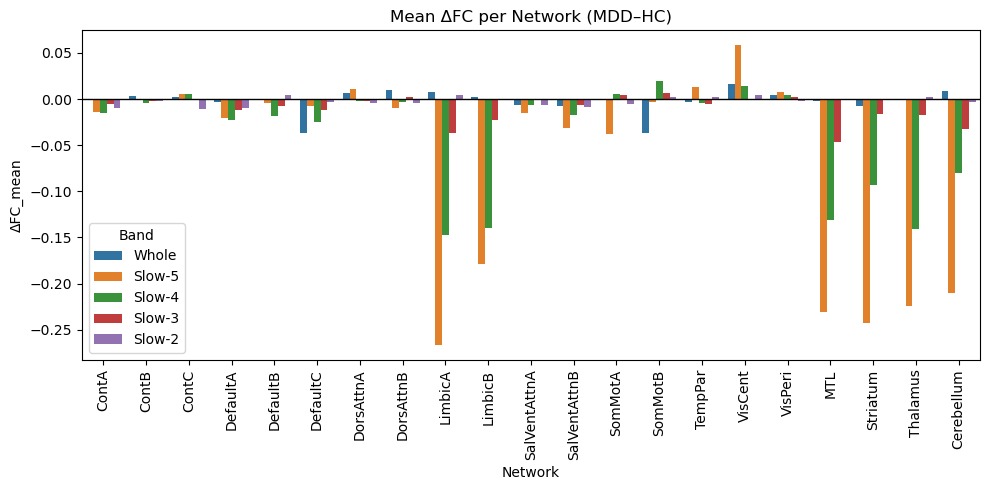

In [12]:
import pandas as pd
import numpy as np

summary = []

for band, subj_fcs in z_binned_netfcs.items():
    subs = list(subj_fcs.keys())
    group_labels = [groups[s] for s in subs]
    mdd = np.array([subj_fcs[s] for s, g in zip(subs, group_labels) if g == "MDD"])
    hc  = np.array([subj_fcs[s] for s, g in zip(subs, group_labels) if g == "HC"])
    
    diff_mat = np.nanmean(mdd, axis=0) - np.nanmean(hc, axis=0)

    # Exclude self-connections
    diff_mat_no_diag = diff_mat.copy()
    np.fill_diagonal(diff_mat_no_diag, np.nan)

    mean_dfc = np.nanmean(diff_mat_no_diag, axis=1)
    
    df_band = pd.DataFrame({
        "Network": net_names_21,
        "ΔFC_mean": mean_dfc,
        "Band": band
    })
    summary.append(df_band)

summary_df = pd.concat(summary)

# plot per band
import seaborn as sns
plt.figure(figsize=(10,5))
sns.barplot(data=summary_df, x="Network", y="ΔFC_mean", hue="Band")
plt.axhline(0, color='k', lw=1)
plt.xticks(rotation=90)
plt.title("Mean ΔFC per Network (MDD–HC)")
plt.tight_layout()
plt.show()

In [13]:
### Network level test
# Delta mean FC: A summary measure of how “shifted” or “biased” a network’s connectivity is between groups.
def compare_band_to_whole_network(summary_df, band, n_perm=10000, random_state=None):
    """
    Tests whether |ΔFC_band| > |ΔFC_whole| on average across networks,
    using paired permutation test AND computes effect sizes.
    """

    rng = np.random.default_rng(random_state)
    
    # Extract whole-band and band rows
    wb = summary_df[summary_df["Band"] == "Whole"].copy()
    bd = summary_df[summary_df["Band"] == band].copy()
    
    # Merge by network
    merged = wb.merge(bd, on="Network", suffixes=("_Whole", f"_{band}"))
    
    # Compute paired differences
    diffs = (
        merged[f"ΔFC_mean_{band}"].abs().values
        - merged["ΔFC_mean_Whole"].abs().values
    )
    
    # Test statistic
    T_real = diffs.mean()
    
    # Permutation of signs
    perm_T = np.zeros(n_perm)
    for p in range(n_perm):
        signs = rng.choice([-1, 1], size=len(diffs))
        perm_T[p] = np.mean(diffs * signs)
    
    # Two-sided permutation p-value
    p_val = np.mean(np.abs(perm_T) >= np.abs(T_real))
    
    # Effect sizes
    mean_d = np.mean(diffs)
    sd_d   = np.std(diffs, ddof=1)
    cohen_d = mean_d / sd_d
    
    # Hedges g correction
    n = len(diffs)
    J = 1 - 3/(4*n - 9)
    hedges_g = cohen_d * J
    
    return {
        "band": band,
        "T_real": T_real,
        "p_perm": p_val,
        "cohen_d": cohen_d,
        "hedges_g": hedges_g,
        "n_networks": n,
        "merged": merged
    }


bands_to_test = ["Slow-5", "Slow-4", "Slow-3", "Slow-2"]
net_results = []

for b in bands_to_test:
    res = compare_band_to_whole_network(summary_df, band=b, n_perm=10000, random_state=42)
    net_results.append(res)

from statsmodels.stats.multitest import multipletests

# example: list of p-values from all tested bands
pvals = [res["p_perm"] for res in net_results]
bands = [res["band"] for res in net_results]

_, pvals_fdr = multipletests(pvals, method="fdr_bh")[:2]

for band, p, pfdr in zip(bands, pvals, pvals_fdr):
    # print results, p corrected
    print(f"{band:>7} p = {p:.4f},  p_FDR = {pfdr:.4f}, Cohen's d = {net_results[bands.index(band)]['cohen_d']:.4f}, Hedges' g = {net_results[bands.index(band)]['hedges_g']:.4f}")

 Slow-5 p = 0.0061,  p_FDR = 0.0192, Cohen's d = 0.6672, Hedges' g = 0.6405
 Slow-4 p = 0.0096,  p_FDR = 0.0192, Cohen's d = 0.6182, Hedges' g = 0.5935
 Slow-3 p = 0.3948,  p_FDR = 0.3948, Cohen's d = 0.1926, Hedges' g = 0.1849
 Slow-2 p = 0.1633,  p_FDR = 0.2177, Cohen's d = -0.3344, Hedges' g = -0.3210


In [14]:
### Which specific networks contributed the most to that increase?
### Networks where Slow-5 adds the most group-difference signal compared to wholeband.
import numpy as np
import pandas as pd

def dir_label(x):
    if x > 0:
        return "MDD > HC"
    elif x < 0:
        return "MDD < HC"
    else:
        return "≈ 0"

def compute_slow5_network_drivers(summary_df,
                                  whole_label="Whole",
                                  band_label="Slow-5",
                                  value_col="ΔFC_mean"):
    """
    Compute, for each network, how much the magnitude of the group difference
    (|ΔFC_mean|) is larger in Slow-5 than in Wholeband.

    Returns a DataFrame sorted from strongest to weakest "driver".
    """

    # 1. Extract Whole and Slow-5 rows
    df_whole = summary_df[summary_df["Band"] == whole_label].copy()
    df_band  = summary_df[summary_df["Band"] == band_label].copy()

    # 2. Merge on Network so each row has Whole + Slow-5 values
    merged = df_whole.merge(
        df_band,
        on="Network",
        suffixes=(f"_{whole_label}", f"_{band_label}")
    )

    # Rename for convenience
    col_whole = f"{value_col}_{whole_label}"
    col_band  = f"{value_col}_{band_label}"

    # 3. Compute absolute differences in magnitude
    merged["abs_whole"] = merged[col_whole].abs()
    merged["abs_band"]  = merged[col_band].abs()

    # d_abs > 0 ⇒ stronger effect in Slow-5 than Whole
    merged["d_abs"] = merged["abs_band"] - merged["abs_whole"]

    # 4. Add direction info (hypo/hyper in Slow-5 and Whole)

    merged["dir_Slow5"] = merged[col_band].apply(dir_label)
    merged["dir_Whole"] = merged[col_whole].apply(dir_label)

    # 5. (Optional) z-score of d_abs across networks, for relative importance
    if merged["d_abs"].std(ddof=1) > 0:
        merged["d_abs_z"] = (merged["d_abs"] - merged["d_abs"].mean()) / merged["d_abs"].std(ddof=1)
    else:
        merged["d_abs_z"] = np.nan

    # 6. Sort: strongest drivers first
    merged_sorted = merged.sort_values("d_abs", ascending=False).reset_index(drop=True)

    return merged_sorted

# ---- usage example ----

drivers_slow5 = compute_slow5_network_drivers(summary_df)

# Look at top 10 networks driving the Slow-5 > Whole difference
print(drivers_slow5[["Network",
                     "ΔFC_mean_Whole",
                     "ΔFC_mean_Slow-5",
                    #  "abs_whole",
                    #  "abs_band",
                     "d_abs",
                     "dir_Whole",
                     "dir_Slow5"]].head(6))


      Network  ΔFC_mean_Whole  ΔFC_mean_Slow-5     d_abs dir_Whole dir_Slow5
0     LimbicA        0.008039        -0.266314  0.258275  MDD > HC  MDD < HC
1    Striatum       -0.008005        -0.242328  0.234323  MDD < HC  MDD < HC
2         MTL       -0.002073        -0.231319  0.229246  MDD < HC  MDD < HC
3    Thalamus        0.000305        -0.224676  0.224370  MDD > HC  MDD < HC
4  Cerebellum        0.008263        -0.209893  0.201630  MDD > HC  MDD < HC
5     LimbicB        0.002151        -0.179199  0.177048  MDD > HC  MDD < HC


In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Determine the "other" network for each edge
def get_partner(row, seed_network):
    return row["Net2"] if row["Net1"] == seed_network else row["Net1"]

def get_network_edges(results_band, seed_network, band_label="Slow-5"):
    """
    Extract all edges involving a given seed network (e.g. LimbicA)
    in a given band (e.g. Slow-5), from the 'results_band' DataFrame.

    Assumes 'results_band' has columns:
        ['Band', 'Net1', 'Net2', 'ΔFC', 'Cohen', 'Hedges', 'p', 'p_FDR', ...]
    """
    # Filter to band of interest
    df_band = results_band[results_band["Band"] == band_label].copy()

    # Keep only edges where the seed network is involved
    mask = (df_band["Net1"] == seed_network) | (df_band["Net2"] == seed_network)
    df_seed = df_band[mask].copy()

    if df_seed.empty:
        print(f"No edges found for {seed_network} in band {band_label}.")
        return df_seed

    df_seed["Connection"] = df_seed.apply(get_partner, axis=1, seed_network=seed_network)

    # Sort by ΔFC (from most negative to most positive)
    df_seed = df_seed.sort_values("ΔFC").reset_index(drop=True)

    # Optional: nicer column ordering
    cols = ["Connection", "ΔFC", "Band"]
    cols = [c for c in cols if c in df_seed.columns]  # keep only existing
    df_seed = df_seed[cols]

    return df_seed


In [16]:
seed = "LimbicA"
band = "Slow-5"

limbica_slow5_edges = get_network_edges(results_band, seed_network=seed, band_label=band)
print(limbica_slow5_edges)


      Connection       ΔFC    Band
0            MTL -2.143188  Slow-5
1       Thalamus -1.001473  Slow-5
2       Striatum -0.938119  Slow-5
3     Cerebellum -0.692148  Slow-5
4        LimbicB -0.324973  Slow-5
5   SalVentAttnB -0.108497  Slow-5
6       DefaultA -0.086011  Slow-5
7       DefaultC -0.060601  Slow-5
8   SalVentAttnA -0.055808  Slow-5
9        SomMotB -0.050095  Slow-5
10      DefaultB -0.041342  Slow-5
11         ContA -0.023746  Slow-5
12       SomMotA -0.012621  Slow-5
13         ContB  0.000809  Slow-5
14       TempPar  0.004329  Slow-5
15       VisPeri  0.010080  Slow-5
16         ContC  0.014253  Slow-5
17     DorsAttnB  0.022483  Slow-5
18     DorsAttnA  0.054973  Slow-5
19       VisCent  0.105425  Slow-5


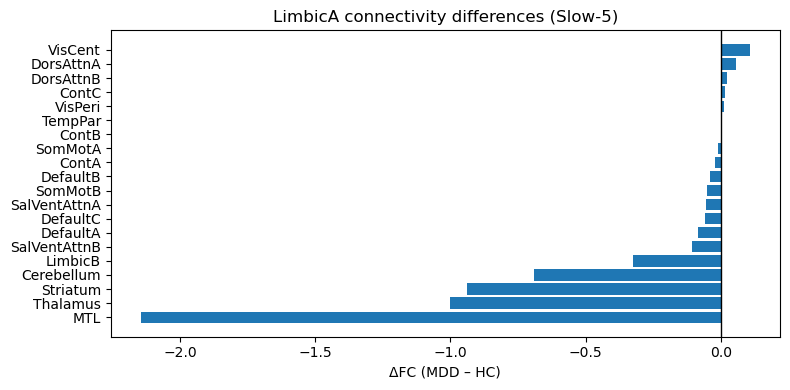

In [17]:
def plot_network_edges(df_seed, seed_network, band_label="Slow-5"):
    """
    Simple barplot of ΔFC for all edges of a seed network in a given band.
    df_seed is the output of get_network_edges().
    """
    if df_seed.empty:
        return

    plt.figure(figsize=(8, 4))
    # sort again just to be sure
    df_plot = df_seed.sort_values("ΔFC")
    
    plt.barh(df_plot["Connection"], df_plot["ΔFC"])
    plt.axvline(0, color="k", linewidth=1)
    plt.xlabel("ΔFC (MDD – HC)")
    plt.title(f"{seed_network} connectivity differences ({band_label})")
    plt.tight_layout()
    plt.show()

# Example:
plot_network_edges(limbica_slow5_edges, seed_network=seed, band_label=band)


#### More analyses

In [18]:

def compute_slow4_network_drivers(summary_df,
                                  whole_label="Whole",
                                  band_label="Slow-4",
                                  value_col="ΔFC_mean"):
    """
    Compute, for each network, how much the magnitude of the group difference
    (|ΔFC_mean|) is larger in Slow-4 than in Wholeband.

    Returns a DataFrame sorted from strongest to weakest "driver".
    """

    # 1. Extract Whole and Slow-5 rows
    df_whole = summary_df[summary_df["Band"] == whole_label].copy()
    df_band  = summary_df[summary_df["Band"] == band_label].copy()

    # 2. Merge on Network so each row has Whole + Slow-4 values
    merged = df_whole.merge(
        df_band,
        on="Network",
        suffixes=(f"_{whole_label}", f"_{band_label}")
    )

    # Rename for convenience
    col_whole = f"{value_col}_{whole_label}"
    col_band  = f"{value_col}_{band_label}"

    # 3. Compute absolute differences in magnitude
    merged["abs_whole"] = merged[col_whole].abs()
    merged["abs_band"]  = merged[col_band].abs()

    # d_abs > 0 ⇒ stronger effect in Slow-5 than Whole
    merged["d_abs"] = merged["abs_band"] - merged["abs_whole"]

    # 4. Add direction info (hypo/hyper in Slow-5 and Whole)

    merged["dir_Slow4"] = merged[col_band].apply(dir_label)
    merged["dir_Whole"] = merged[col_whole].apply(dir_label)

    # 5. (Optional) z-score of d_abs across networks, for relative importance
    if merged["d_abs"].std(ddof=1) > 0:
        merged["d_abs_z"] = (merged["d_abs"] - merged["d_abs"].mean()) / merged["d_abs"].std(ddof=1)
    else:
        merged["d_abs_z"] = np.nan

    # 6. Sort: strongest drivers first
    merged_sorted = merged.sort_values("d_abs", ascending=False).reset_index(drop=True)

    return merged_sorted

# ---- usage example ----

drivers_slow4 = compute_slow4_network_drivers(summary_df)

# Look at top 10 networks driving the Slow-4 > Whole difference
print(drivers_slow4[["Network",
                     "ΔFC_mean_Whole",
                     "ΔFC_mean_Slow-4",
                    #  "abs_whole",
                    #  "abs_band",
                     "d_abs",
                     "dir_Whole",
                     "dir_Slow4"]].head(6))

      Network  ΔFC_mean_Whole  ΔFC_mean_Slow-4     d_abs dir_Whole dir_Slow4
0    Thalamus        0.000305        -0.140596  0.140291  MDD > HC  MDD < HC
1     LimbicA        0.008039        -0.147701  0.139662  MDD > HC  MDD < HC
2     LimbicB        0.002151        -0.139331  0.137180  MDD > HC  MDD < HC
3         MTL       -0.002073        -0.131491  0.129418  MDD < HC  MDD < HC
4    Striatum       -0.008005        -0.093127  0.085122  MDD < HC  MDD < HC
5  Cerebellum        0.008263        -0.080169  0.071906  MDD > HC  MDD < HC


      Connection       ΔFC    Band
0            MTL -0.693192  Slow-4
1       Thalamus -0.559360  Slow-4
2        LimbicB -0.501985  Slow-4
3       Striatum -0.439666  Slow-4
4     Cerebellum -0.435030  Slow-4
5       DefaultC -0.094570  Slow-4
6       DefaultA -0.089043  Slow-4
7       DefaultB -0.084410  Slow-4
8   SalVentAttnB -0.073252  Slow-4
9        TempPar -0.059797  Slow-4
10         ContA -0.046101  Slow-4
11  SalVentAttnA -0.032541  Slow-4
12         ContB -0.024928  Slow-4
13     DorsAttnA  0.000949  Slow-4
14       VisPeri  0.010466  Slow-4
15     DorsAttnB  0.012384  Slow-4
16         ContC  0.013583  Slow-4
17       SomMotB  0.041333  Slow-4
18       SomMotA  0.041888  Slow-4
19       VisCent  0.059263  Slow-4


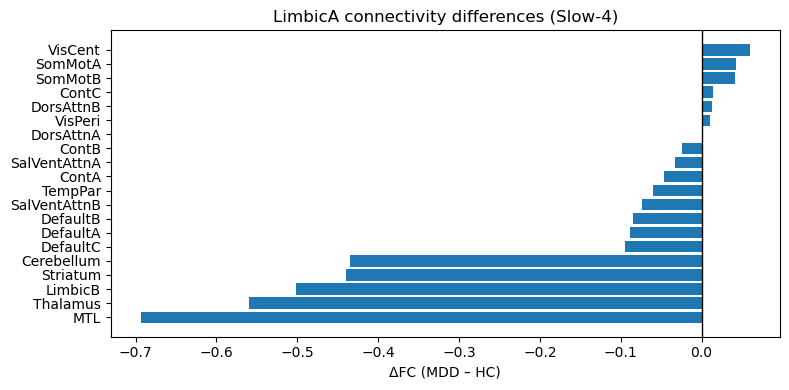

In [19]:
seed = "LimbicA"
band = "Slow-4"

limbica_slow4_edges = get_network_edges(results_band, seed_network=seed, band_label=band)
print(limbica_slow4_edges)

plot_network_edges(limbica_slow4_edges, seed_network=seed, band_label=band)

In [20]:
def compute_slow3_network_drivers(summary_df,
                                  whole_label="Whole",
                                  band_label="Slow-3",
                                  value_col="ΔFC_mean"):
    """
    Compute, for each network, how much the magnitude of the group difference
    (|ΔFC_mean|) is larger in Slow-4 than in Wholeband.

    Returns a DataFrame sorted from strongest to weakest "driver".
    """

    # 1. Extract Whole and Slow-5 rows
    df_whole = summary_df[summary_df["Band"] == whole_label].copy()
    df_band  = summary_df[summary_df["Band"] == band_label].copy()

    # 2. Merge on Network so each row has Whole + Slow-4 values
    merged = df_whole.merge(
        df_band,
        on="Network",
        suffixes=(f"_{whole_label}", f"_{band_label}")
    )

    # Rename for convenience
    col_whole = f"{value_col}_{whole_label}"
    col_band  = f"{value_col}_{band_label}"

    # 3. Compute absolute differences in magnitude
    merged["abs_whole"] = merged[col_whole].abs()
    merged["abs_band"]  = merged[col_band].abs()

    # d_abs > 0 ⇒ stronger effect in Slow-5 than Whole
    merged["d_abs"] = merged["abs_band"] - merged["abs_whole"]

    # 4. Add direction info (hypo/hyper in Slow-5 and Whole)

    merged["dir_Slow3"] = merged[col_band].apply(dir_label)
    merged["dir_Whole"] = merged[col_whole].apply(dir_label)

    # 5. (Optional) z-score of d_abs across networks, for relative importance
    if merged["d_abs"].std(ddof=1) > 0:
        merged["d_abs_z"] = (merged["d_abs"] - merged["d_abs"].mean()) / merged["d_abs"].std(ddof=1)
    else:
        merged["d_abs_z"] = np.nan

    # 6. Sort: strongest drivers first
    merged_sorted = merged.sort_values("d_abs", ascending=False).reset_index(drop=True)

    return merged_sorted

# ---- usage example ----

drivers_slow3 = compute_slow3_network_drivers(summary_df)

# Look at top 10 networks driving the Slow-4 > Whole difference
print(drivers_slow3[["Network",
                     "ΔFC_mean_Whole",
                     "ΔFC_mean_Slow-3",
                    #  "abs_whole",
                    #  "abs_band",
                     "d_abs",
                     "dir_Whole",
                     "dir_Slow3"]].head(6))

      Network  ΔFC_mean_Whole  ΔFC_mean_Slow-3     d_abs dir_Whole dir_Slow3
0         MTL       -0.002073        -0.046759  0.044686  MDD < HC  MDD < HC
1     LimbicA        0.008039        -0.036932  0.028893  MDD > HC  MDD < HC
2  Cerebellum        0.008263        -0.031906  0.023642  MDD > HC  MDD < HC
3     LimbicB        0.002151        -0.022646  0.020495  MDD > HC  MDD < HC
4    Thalamus        0.000305        -0.016841  0.016535  MDD > HC  MDD < HC
5    DefaultA       -0.002931        -0.012367  0.009436  MDD < HC  MDD < HC


      Connection       ΔFC    Band
0            MTL -0.337416  Slow-3
1        LimbicB -0.087829  Slow-3
2       Thalamus -0.071661  Slow-3
3       Striatum -0.056015  Slow-3
4     Cerebellum -0.053339  Slow-3
5       DefaultA -0.044153  Slow-3
6       DefaultC -0.039195  Slow-3
7       DefaultB -0.027206  Slow-3
8   SalVentAttnB -0.025336  Slow-3
9          ContA -0.018610  Slow-3
10       TempPar -0.018464  Slow-3
11         ContB -0.018125  Slow-3
12     DorsAttnA -0.008131  Slow-3
13         ContC  0.000250  Slow-3
14  SalVentAttnA  0.000578  Slow-3
15       VisCent  0.001668  Slow-3
16     DorsAttnB  0.009783  Slow-3
17       VisPeri  0.010204  Slow-3
18       SomMotA  0.021042  Slow-3
19       SomMotB  0.023318  Slow-3


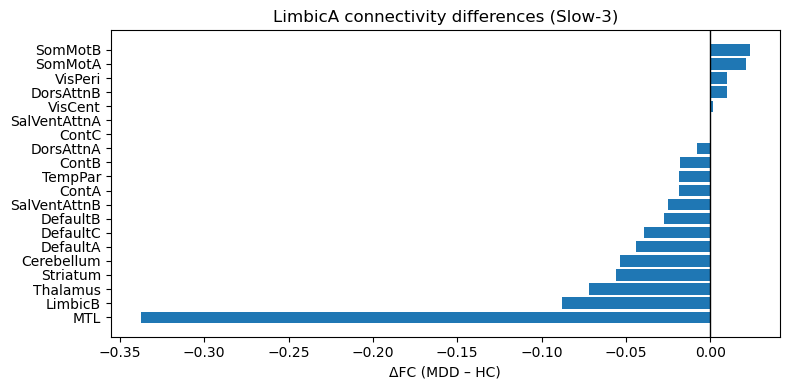

In [21]:
seed = "LimbicA"
band = "Slow-3"

limbica_slow3_edges = get_network_edges(results_band, seed_network=seed, band_label=band)
print(limbica_slow3_edges)

plot_network_edges(limbica_slow3_edges, seed_network=seed, band_label=band)